#########################################
#  Sample Program using Kalman Filter   #

#  2. Optimization of Model Parameters  #
#########################################

In [ ]:
# python 3.5 or greater

#import modules
import numpy as np
import sys
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from scipy.optimize import LinearConstraint as LS


In [ ]:
def KalmanFilter(a0,P0,dt,ct,Tt,Zt,HHt,GGt,yt):
    ## Check classes of arguments

    stor_type = {"a0" : a0, "P0" : P0, "dt" : dt,
                   "ct" : ct, "Tt" : Tt, "Zt" : Zt,
                   "HHt" : HHt, "GGt" : GGt, "yt" : yt}
    not_ndarray = [key for key,value in stor_type.items()
    if not isinstance(value,np.ndarray)]
    if(not_ndarray):
        sys.exit("'" + ', '.join(not_ndarray) +
        "' must be class 'numpy.ndarray'")

    ## Check the storage type: Must be 'float64' ('float') for all arguments

    not_float = [key for key,value in stor_type.items() if not value.dtype=='float']
    if(not_float):
        sys.exit("Storage mode of variable(s) '" + ', '.join(not_float)
        + "' is not double!")

    ## Check compatibility of dimensions
    #### ! we do not cosider here time-varying system
    n = yt.shape[1]
    d = yt.shape[0]
    m = len(a0)
    if(P0.shape[1] != m or P0.shape[0] != m or dt.shape[0] != m or
       Zt.shape[1] != m or HHt.shape[0] != m or HHt.shape[1] != m  or
       Tt.shape[0] != m  or Tt.shape[1] != m):
       sys.exit("Some of P0.shape[1], P0.shape[0], dt.shape[0],\n"+
             "Zt.shape[1], HHt.shape[0], HHt.shape[1],\n"+
             "Tt.shape[0] or Tt.shape[1] is/are not equal to 'm'!\n")

    if(ct.shape[0] != d or Zt.shape[0] != d  or
       GGt.shape[0]!= d  or GGt.shape[1] != d  or yt.shape[0] != d):
        sys.exit("Some of ct.shape[0], Zt.shape[0], GGt.shape[0],\n"+
             "GGt.shape[1] or yt.shape[0] is/are not equal to 'd'!\n")

    ## simulation
    ### initialization
    at = np.zeros((m,n+1)); at[:,0] = a0 # predicted state variables
    Pt = np.zeros((m,m,n+1)); Pt[:,:,0] = P0 # variances of at
    vt = np.zeros((d,n)) # prediction errors
    Ft = np.zeros((d,d,n)) # variances of vt
    Kt = np.zeros((m,d,n)) # kalman gain
    att = np.zeros((m,n)) # filtered state variables
    Ptt = np.zeros((m,m,n)) # variance of at
    logLik = -1/2 * yt.shape[1] * d * np.log(2*np.pi) # constant part of logLik
    for i in range(n):
        y_pred = Zt @ at[:,i] + ct
        #updating...
        vt[:,i] = yt[:,i] - y_pred #prediction error
        Ft[:,:,i] = Zt @ Pt[:,:,i] @ Zt.T + GGt # variances of vt
        Kt[:,:, i] = Pt[:,:,i] @ Zt.T @ np.linalg.inv(Ft[:,:, i]) #kalman gain
        att[:,i] =  at[:,i] + Kt[:,:,i] @ vt[:,i] # filtered state variables
        Ptt[:,:,i] = Pt[:,:,i] - Pt[:,:,i] @ Zt.T @ Kt[:,:,i].T # filetered state variables
        logLik += -1/2 * ( np.log(np.linalg.det(Ft[:,:,i])) + vt[:,i].T @ np.linalg.inv(Ft[:,:,i]) @ vt[:,i]) # update loglikelihood
        #prediction
        at[:,i+1] = dt + Tt @ att[:,i] #prediction
        Pt[:,:,i+1] = Tt @ Ptt[:,:,i] @ Tt.T + HHt #prediction


    return {"att":att,"at":at,"Ptt":Ptt,"Pt":Pt,"vt":vt,"Ft":Ft,"Kt":Kt,"logLik":logLik}


In [ ]:
Nt = 100          # number of time points
a0 = np.array([0.0])    # initial state vector (x0)
P0 = np.array([[0.01]])   # initial covariance matrix (V0)
dt =np.array([0.0])  # mean vector of system noise
ct =np.array([0.0])   # mean vector of observation noise
Tt =np.array([[1.0]])   # transition matrix (Ft)
Zt =np.array([[1.0]])   # observation matrix (Ht)

HHt_T = 1.0        # variance of system noise (true)
HHt_F = 0.2        # variance of system noise (false)
GGt_T = 4.0        # variance of observation noise (true)
GGt_F = 1.0        # variance of observation noise (false)
Ht = np.array([[HHt_F]]) # covariance matrix of system noise (Qt)
Gt = np.array([[GGt_F]]) # covariance matrix of observation noise (Rt)

# synthetic data
xt = np.cumsum( np.random.normal( size = Nt, loc=0, scale=np.sqrt(HHt_T) ) )      # state vector
yt = xt + np.random.normal( size=Nt, loc=0, scale=np.sqrt(GGt_T) ) # observation data
yt = yt.reshape(1,len(yt))  #reshape to matrix

a0_F = np.array([50.0])

In [ ]:
#objective function
def J(x,P0,dt,ct,Tt,Zt,yt): #return negative of log-likelihood
    a0 = np.array([x[0]]); HHt = np.array([[x[1]]]); GGt = np.array([[x[2]]]);
    return -KalmanFilter(a0,P0,dt,ct,Tt,Zt,HHt,GGt,yt)["logLik"]

In [ ]:
#optimization
constraint = LS(np.array([[0,1,0],[0,0,1]]), 0, np.inf)
xopt = minimize(J, np.array([a0_F[0], HHt_F, GGt_F]),args=(P0,dt,ct,Tt,Zt,yt), constraints=constraint)
print(f"a0,HHt,GGtの推測値{xopt.x}")

In [ ]:
# Kalman filter using the optimzed parameters
KF = KalmanFilter( np.array([xopt.x[0]]), P0, dt, ct, Tt, Zt, np.array([[xopt.x[1]]]), np.array([[xopt.x[2]]]), yt)

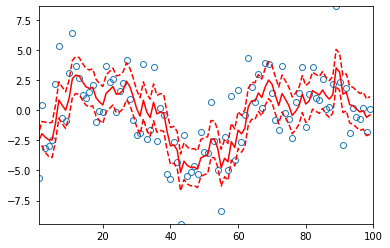

-240.54169457820262


In [ ]:
# plot
plt.xlim(1,Nt)
plt.ylim(min(yt[0]),max(yt[0]))
plt.plot(yt[0],mfc='None', marker='o', linestyle='None')
filt = KF["att"][0]; filt_std = KF["Ptt"][0,0,:]
plt.plot(KF["att"][0],color='red')
plt.plot(KF["att"][0] - filt_std, linestyle='dashed',color='red')
plt.plot(KF["att"][0] + filt_std, linestyle='dashed',color='red')
plt.show()
print(KF["logLik"])